# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection \
    import train_test_split, GridSearchCV, cross_val_score
import optuna

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

## Данные о клиентах банка:

age (возраст);  
job (сфера занятости);  
marital (семейное положение);  
education (уровень образования);  
default (имеется ли просроченный кредит);  
housing (имеется ли кредит на жильё);  
loan (имеется ли кредит на личные нужды);  
balance (баланс).  

**Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:**

contact (тип контакта с клиентом);  
month (месяц, в котором был последний контакт);  
day (день, в который был последний контакт);  
duration (продолжительность контакта в секундах).  

**Прочие признаки:**

campaign (количество контактов с этим клиентом в течение текущей кампании);  
pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);  
previous (количество контактов до текущей кампании);  
poutcome (результат прошлой маркетинговой кампании).  

**Целевая переменная** deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [2]:
df = pd.read_csv('bank_fin.zip', sep = ';')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [4]:
# Исследуем данные на предмет пропусков.
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

In [5]:
df['balance']

0         2 343,00 $ 
1            45,00 $ 
2         1 270,00 $ 
3         2 476,00 $ 
4           184,00 $ 
             ...     
11157         1,00 $ 
11158       733,00 $ 
11159        29,00 $ 
11160           0  $ 
11161           0  $ 
Name: balance, Length: 11162, dtype: object

In [6]:
# Преобразуем признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].apply (lambda x: float(str(x).replace('$','').replace(' ','').replace(',','.')))

# Обработаем пропуски в признаки balance , заменив их на медианные значения по данному признаку
med_bal = df['balance'].median()
df['balance'].fillna(med_bal, inplace=True)

In [7]:
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [8]:
df['education'].value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

In [9]:
# Обработаем пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['education'].replace('unknown', 'secondary',  inplace=True)
df['job'].replace('unknown', 'management',  inplace=True)

In [10]:
# Удалим все выбросы для признака balance
# Применим заготовленную функцию для удаления выбросов методом Тьюки:

def drop_iqr(df, col, left=1.5, right=1.5, log_scale=False, add_one=False):
    """Drop outliers using the interquartile range method (Tukey's method)

    Args:
        df (DataFrame): pandas DataFrame
        col (str): column name
        log_scale (bool, optional): converting to the natural log scale. 
                                    Defaults to False.
        add_one (bool, optional): add 1 to all values, 
                                  (works for the log scale only,
                                  usefull if there are zeros in data). 
                                  Defaults to False.
        left (float, optional): lower IQR bound. Defaults to 1.5.
        right (float, optional): upper IQR bound. Defaults to 1.5.

    Returns:
        tuple: a tuple containing the cleaned dataframe, the calculated 
               lower and upper bounds, and the dataframe with outliers
    """
    
    if log_scale and add_one:
        x = np.log(df[col]+1)
    elif log_scale and not add_one:
        x = np.log(df[col])
    else:
        x = df[col]
    
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr*left)
    upper_bound = quartile_3 + (iqr*right)
    outliers = df[(x<lower_bound) | (x>upper_bound)]
    clean_df = df[(x>=lower_bound) & (x<=upper_bound)]
    
    return clean_df, lower_bound, upper_bound, outliers


df, lower_bound, upper_bound, _ = drop_iqr(df, 'balance')
print(lower_bound, upper_bound, df.shape[0])

-2241.0 4063.0 10105


## Часть 2:  Разведывательный анализ

no     5424
yes    4681
Name: deposit, dtype: int64

no     0.536764
yes    0.463236
Name: deposit, dtype: float64

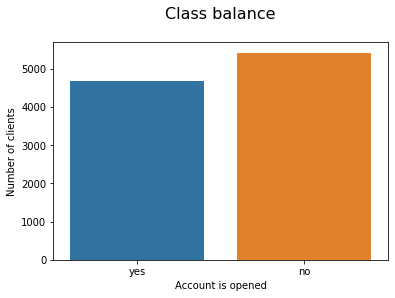

In [11]:
# Изучим соотношение классов в данных на предмет несбалансированности, проиллюстрируем результат.
display(df['deposit'].value_counts())
display(df['deposit'].value_counts(normalize=True))

ax = sns.countplot(df['deposit'])
ax.set(xlabel='Account is opened', ylabel='Number of clients')
ax.set_title('Class balance\n',fontsize=16);

Данные можно считать сбалансированными

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


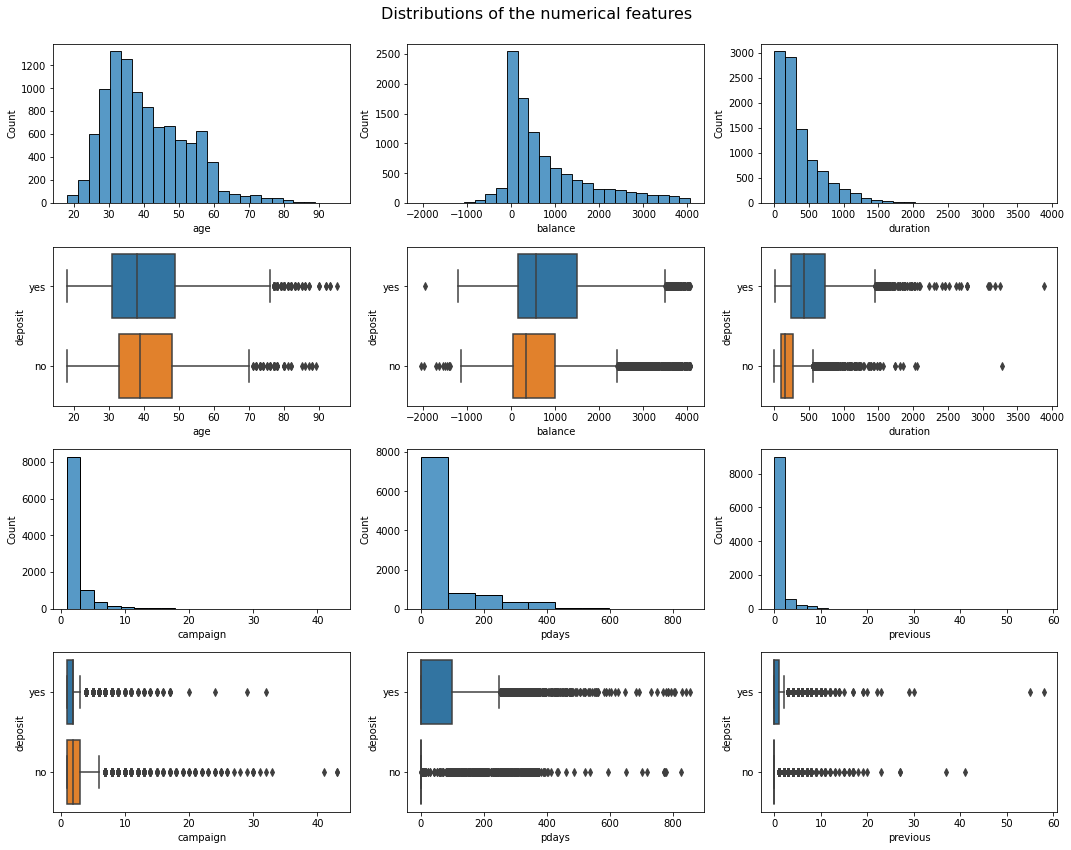

In [12]:
# Рассчитаем описательные статистики для количественных переменных, проинтерпретируем результат

display(df.describe())

fig, ax = plt.subplots(4,3, figsize=(15,12))
sns.histplot(df['age'], bins=25, ax=ax[0,0])       # Возраст
sns.histplot(df['balance'], bins=25, ax=ax[0,1])   # Баланс
sns.histplot(df['duration'], bins=25, ax=ax[0,2])  # Продолжительность контакта
sns.boxplot(data=df, x='age', y='deposit', ax=ax[1,0]) 
sns.boxplot(data=df, x='balance', y='deposit', ax=ax[1,1])
sns.boxplot(data=df, x='duration', y='deposit', ax=ax[1,2])
sns.histplot(df['campaign'], bins=20, ax=ax[2,0])  # Количество контактов
sns.histplot(df['pdays'], bins=10, ax=ax[2,1])     # Количество дней после предыдущей кампании
sns.histplot(df['previous'], bins=25, ax=ax[2,2])  # Количество предыдущих контактов
sns.boxplot(data=df, x='campaign', y='deposit', ax=ax[3,0])
sns.boxplot(data=df, x='pdays', y='deposit', ax=ax[3,1])
sns.boxplot(data=df, x='previous', y='deposit', ax=ax[3,2])
plt.suptitle('Distributions of the numerical features\n', fontsize=16)
plt.tight_layout()

### Общий вид распределений, выбросы
***Возраст (age).*** Пик распределения возраста приходится на 30-35 лет с достаточно большим количеством клиентов допенсионного возраста, количество клиентов старше 60 лет резко падает. Распределение с правой асимметрией в сторону старшего возраста.  

***Баланс (balance).*** Есть небольшое количество отрацительных балансов. В остальном распределение логнормальное с преобладанием небольших балансов. Возможно, следует дополнительно убрать выбросы отрицательного баланса, расположенные левее границы распределения (менее ~ -1100).  

***Продолжительность контакта (duration).*** Средняя продолжительность контакта около 5 мин. Распределение логнормальное. Возможно наличие выбросов - контакт более 30 мин.  

***Количество контактов (campaign).*** Логнормальное. Выбросы - число контактов более 15.  

***Количество дней с момента предыдущей кампании (pdays).*** Логнормальное. Выбросы - более 500 дней.  

***Количество предыдущих контактов (previous).*** Логнормальное. Выбросы аналогичны признаку campaign - более 15.  

Для более точного определения границ распределений и удаления выбросов желательно предварительно преобразовать часть признаков в логарифмическую шкалу и применить критерий Тьюки или 3-сигма.

### Влияние на целевой признак  

Визуально значимые отличия в распределениях по отношению к целевому признаку - открытию депозита (deposit) - наблюдаются у нескольких признаков (см. диаграммы размаха). На вероятное открытие депозита указывает продолжительность контакта - чем он дольше, тем выше шансы положительного результата. Наоборот, большее количество контактов говорит о меньших шансах, т.е. попытки контактировать с клиентом более нескольких раз не имеют особого смысла, результат либо достигается при первых контактах, либо не достигается вообще. Более вероятно открытие депозита у клиентов с большей суммой на счете. Распределение признаков pdays и previous говорит о том, что старый друг лучше новых двух - большинство клиентов, не открывших депозит, относятся к новым (pdays=-1, previous=0). Распределение по возрасту для клиентов, не открывших депозит, имеет меньшую дисперсию по сравнению с открывшими, но медианные значения почти не отличаются.

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


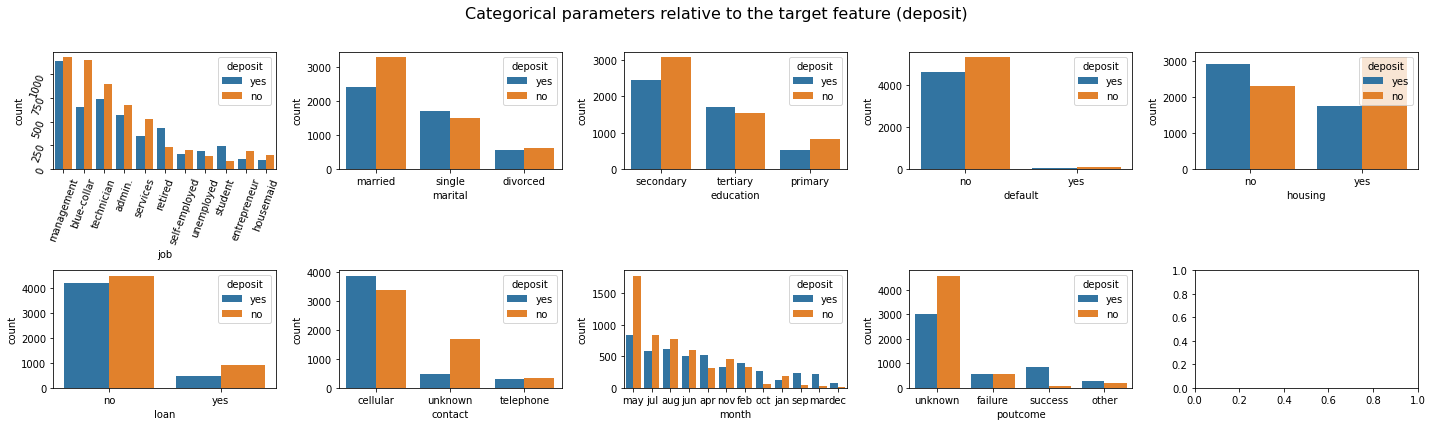

In [13]:
# Рассчитаем описательные статистики для категориальных переменных, проинтерпретируем результат
# Построим визуализации, иллюстрирующие результаты

display(df.describe(include='object'))

fig, ax = plt.subplots(2,5, figsize=(20,6))

# Сфера занятости
sns.countplot(
    data=df, x='job', hue='deposit', 
    order=df['job'].value_counts().index, ax=ax[0,0])

# Семейное положение
sns.countplot(
    data=df, x='marital', hue='deposit',
    order=df['marital'].value_counts().index, ax=ax[0,1])

# Уровень образования
sns.countplot(
    data=df, x='education', hue='deposit',
    order=df['education'].value_counts().index, ax=ax[0,2])

# Наличие просроченного кредита
sns.countplot(
    data=df, x='default', hue='deposit',
    order=df['default'].value_counts().index, ax=ax[0,3])

# Наличие ипотеки
sns.countplot(
    data=df, x='housing', hue='deposit',
    order=df['housing'].value_counts().index, ax=ax[0,4])

# Наличие потребительского кредита
sns.countplot(
    data=df, x='loan', hue='deposit',
    order=df['loan'].value_counts().index, ax=ax[1,0])

# Тип контакта с клиентом
sns.countplot(
    data=df, x='contact', hue='deposit', 
    order=df['contact'].value_counts().index, ax=ax[1,1])

# Месяц последнего контакта с клиентом
sns.countplot(
    data=df, x='month', hue='deposit',
    order=df['month'].value_counts().index, ax=ax[1,2])

# Результат предыдущей маркетинговой кампании
sns.countplot(
    data=df, x='poutcome', hue='deposit',
    order=df['poutcome'].value_counts().index, ax=ax[1,3])
ax[0,0].tick_params(labelrotation=70)
plt.suptitle(
    'Categorical parameters relative to the target feature (deposit)\n',
    fontsize=16)
plt.tight_layout()

In [14]:
# Посмотрим, для какого статуса предыдущей маркетинговой кампании успех 
# в текущей превалирует над количеством неудач.
df.groupby("poutcome")['deposit'].value_counts(normalize=True).unstack('deposit')['yes'].idxmax()

'success'

In [15]:
# Посмотрим, в каком месяце чаще всего отказывались от предложения открыть депозит
df.groupby('month')['deposit'].value_counts(normalize=True).unstack('deposit')['no'].idxmax()

'may'

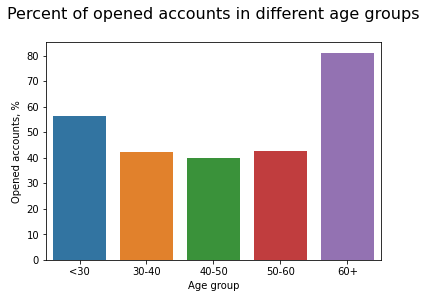

In [16]:
# Создадим возрастные группы и определим, 
# в каких группах более склонны открывать депозит, чем отказываться от предложения
labels=['<30', '30-40', '40-50', '50-60', '60+']
df['age_group'] = pd.cut(df.age, [0,30,40,50,60,9999], 
                         labels = ['<30','30-40','40-50','50-60','60+'])

piv_tab = (df.groupby('age_group')['deposit'].value_counts(normalize=True) \
    * 100).unstack().reset_index() # процент отказов/согласия по группам
ax = sns.barplot(
    data=piv_tab, x='age_group', y='yes', 
 #   order=['youth', 'thirties', 'forties', 'fifties', 'elders']
    )
ax.set(ylabel='Opened accounts, %', xlabel='Age group')
ax.set_title('Percent of opened accounts in different age groups\n', 
             fontsize=16);

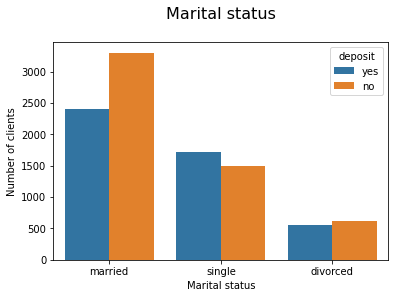

In [17]:
# Построим визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

ax = sns.countplot(data=df, x='marital', hue='deposit')
ax.set(xlabel='Marital status', ylabel='Number of clients')
ax.set_title('Marital status\n', fontsize=16);

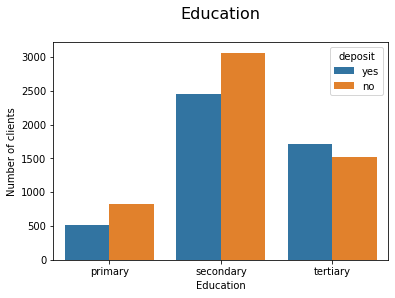

In [18]:
# Построим визуализации для открывших и неоткрывших депозит в зависимости от образования

ax = sns.countplot(data=df, x='education', hue='deposit',
              order=['primary', 'secondary', 'tertiary'])
ax.set(xlabel='Education', ylabel='Number of clients')
ax.set_title('Education\n', fontsize=16);

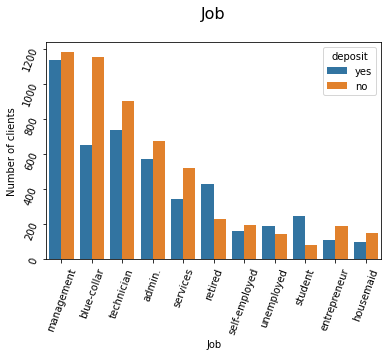

In [19]:
# Построим визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

ax= sns.countplot(data=df, x='job', hue='deposit', 
              order=df['job'].value_counts().index)
ax.tick_params(labelrotation=70)
ax.set(xlabel='Job', ylabel='Number of clients')
ax.set_title('Job\n', fontsize=16);

Выделяется малый процент открытия депозитов у "синих воротничков" и большой - у пенсионеров и студентов. Важно отметить, что при этом "синие воротнички" составляют вторую по численности категорию клиентов (стоить подумать о способах привлечения этой категории).

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


marital,divorced,married,single
education,,,
primary,91,641,100
secondary,370,1830,866
tertiary,163,832,531


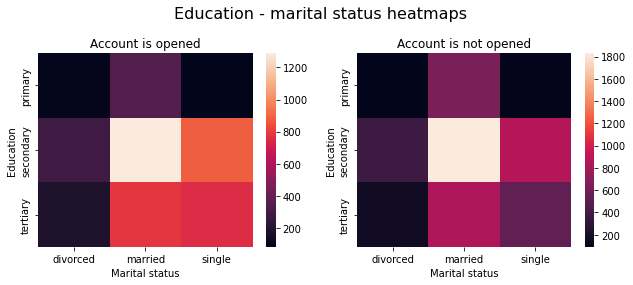

In [20]:
# Построим сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны

#Для тех, кто открыл депозит
success = df[df['deposit']=='yes']
fail = df[df['deposit']=='no']

success_pivot = pd.pivot_table(success,     
    index='education', columns='marital', values='age', aggfunc='count')

#Для тех, кто не открыл депозит  
fail_pivot = fail.groupby(
    ['education', 'marital'])['marital'].count().unstack()

display(success_pivot, fail_pivot)

fig, ax = plt.subplots( 1, 2, figsize=(9,4))
sns.heatmap(success_pivot, ax=ax[0])
sns.heatmap(fail_pivot, ax=ax[1])
ax[0].set_title('Account is opened')
ax[1].set_title('Account is not opened')
ax[0].set(xlabel='Marital status', ylabel='Education')
ax[1].set(xlabel='Marital status', ylabel='Education')
plt.suptitle('Education - marital status heatmaps', fontsize=16)
plt.tight_layout()

## Часть 3: преобразование данных

In [21]:
# Преобразуем возрастные группы
# 0 - '30-40', 1 - '40-50', 2 - '50-60', 3 - '60+', 4 - '<30',
label_enc = preprocessing.LabelEncoder()
df['age_group'] = label_enc.fit_transform(df['age_group'])

In [22]:
# Преобразуем уровни образования
# 0 - primary, 1 - secondary, 2 - tertiary
label_enc = preprocessing.LabelEncoder()
df['education'] = label_enc.fit_transform(df['education'])

In [23]:
# Преобразуем бинарные переменные в представление из нулей и единиц

df.replace({'yes': 1, 'no': 0}, inplace=True)

In [24]:
# Создадим дамми-переменные
dummies = pd.get_dummies(df[[
    'job', 'marital', 'contact', 'month', 'poutcome']], drop_first=False)
df = pd.concat([df, dummies], axis=1)

In [25]:
# Удаляем преобразованные признаки типа object

obj_cols = df.select_dtypes('object').columns
df.drop(columns=obj_cols, inplace=True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_group          10105 non-null  int32  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

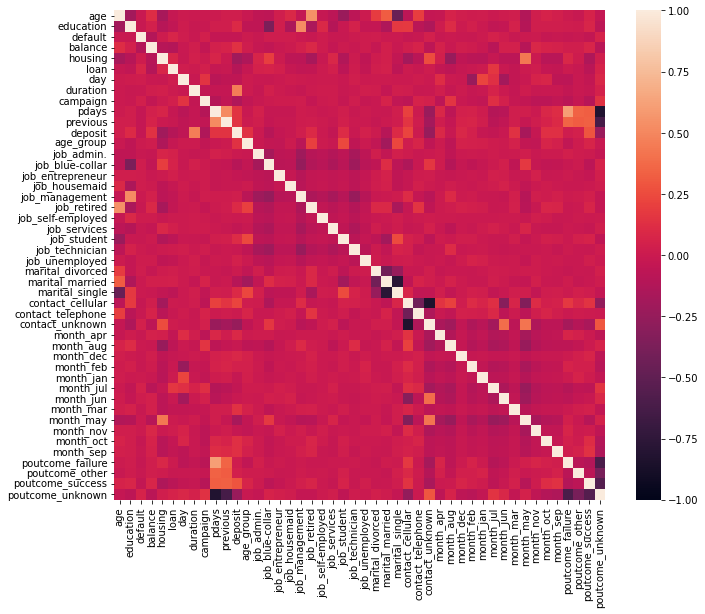

In [27]:
# Построим корреляционную матрицу и оценим данные на предмет наличия мультиколлинеарности
# Используем корреляцию Пирсона 
corr_matrix = df.corr()

# Тепловая карта
fig = plt.figure(figsize=(11,9))
sns.heatmap(corr_matrix,  vmin=-1, vmax=1);

In [28]:
# Вычисляем мультиколлинеарные признаки, порог 0.9 

# Используем заготовленную функцию определения мультиколлинеарных признаков

def get_correlated(corr_matrix, thres=0.7):
    """Getting correlated pairs from a correlation matrix 
       with correlation coefficients higher than the threshold

    Args:
        corr_matrix (pandas DataFrame): correlation matrix (e.g., from df.corr())
        thres (float, optional): threshold. Defaults to 0.7 (i.e., coeff > 0.7 or coeff < -0.7).

    Returns:
        pandas Series: correlated pairs and correlation coefficients
    """
    
    correlated_pairs = {}
    
    for col in corr_matrix.columns:
        positive_filter = corr_matrix[col] >= thres
        negative_filter = corr_matrix[col] <= -thres
        match_series = corr_matrix[col][positive_filter | negative_filter]
        for match in match_series.index:
            if match != col and match + ' -- ' + col not in correlated_pairs.keys():
                correlated_pairs.update({col + ' -- ' + match: match_series[match]})
   
    return pd.Series(correlated_pairs).sort_values()


get_correlated(corr_matrix, thres=0.9)

Series([], dtype: float64)

Признаков, подлежащих удалению не обнаружено

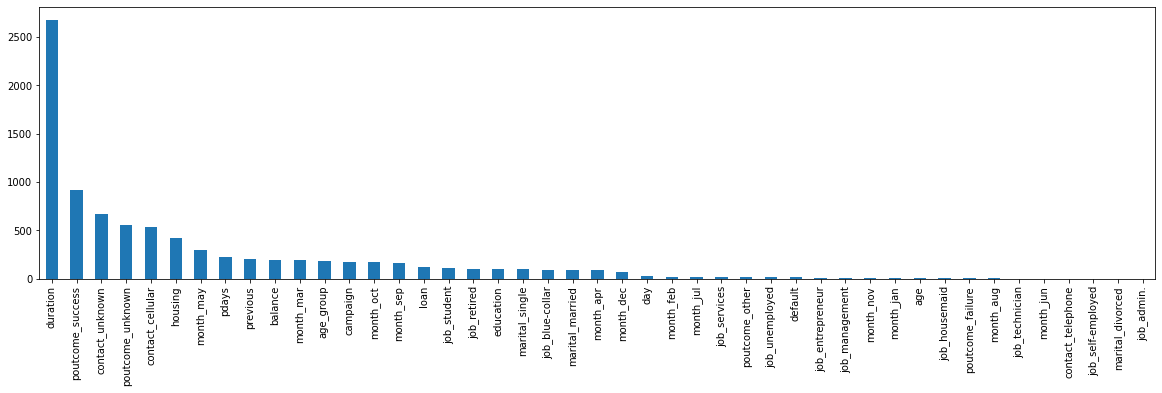

In [29]:
# Используем дисперсионный анализ, показывающий нам различия между признаками
# Определим целевую переменную и предикторы
X = df.drop(['deposit'], axis=1)
y = df['deposit']

# визуализируем результат анализа значимости:
imp = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp.sort_values(inplace = True, ascending=False)

fig, ax = plt.subplots(figsize=(20, 5))
imp.plot(kind = 'bar');

In [39]:
# Разделим выборку на обучающую и тестовую, размер тестовой выборки 0.33.
# Аргумент stratify определяет сохранение соотношений целевого признака.
 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y, test_size = 0.33)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.

С помощью SelectKBest отберем 15 признаков, наилучшим образом подходящих для использования в задаче. Отбор реализуем по обучающей выборке, используя параметр score_func = f_classif.

In [40]:
# с помощью SelectKBest отберем 15 наиболее подходящих признаков

selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train, y_train)
selected_cols = selector.get_feature_names_out()
print(f'Selected features:\n {selected_cols}')
X_train = selector.transform(X_train)
X_test =selector.transform(X_test)

Selected features:
 ['balance' 'housing' 'duration' 'campaign' 'pdays' 'previous' 'age_group'
 'contact_cellular' 'contact_unknown' 'month_mar' 'month_may' 'month_oct'
 'month_sep' 'poutcome_success' 'poutcome_unknown']


In [41]:
# Нормализуем предикторы в обучающей и тестовой выборках с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

In [42]:
# Обучим логистическую регрессию и рассчитаем метрики качества

logregr = linear_model.LogisticRegression(
    random_state=42, solver='sag', max_iter=1000)
logregr.fit(X_train, y_train)
y_train_pred = logregr.predict(X_train)
y_test_pred = logregr.predict(X_test)
print('Обучающая выборка:\n{}'.format(
    metrics.classification_report(y_train, y_train_pred, digits=3)))
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred, digits=3)))

Обучающая выборка:
              precision    recall  f1-score   support

           0      0.810     0.878     0.843      3634
           1      0.843     0.761     0.800      3136

    accuracy                          0.824      6770
   macro avg      0.827     0.819     0.821      6770
weighted avg      0.825     0.824     0.823      6770

Тестовая выборка:
              precision    recall  f1-score   support

           0      0.793     0.870     0.830      1790
           1      0.830     0.737     0.781      1545

    accuracy                          0.808      3335
   macro avg      0.812     0.804     0.805      3335
weighted avg      0.810     0.808     0.807      3335



In [43]:
# Обучим решающие деревья, глубина -  максимальная

dtree = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
dtree.fit(X_train, y_train)
y_train_pred = dtree.predict(X_train)
y_test_pred = dtree.predict(X_test)
print('Обучающая выборка:\n{}'.format(
    metrics.classification_report(y_train, y_train_pred, digits=3)))
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred, digits=3)))

Обучающая выборка:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      3634
           1      1.000     1.000     1.000      3136

    accuracy                          1.000      6770
   macro avg      1.000     1.000     1.000      6770
weighted avg      1.000     1.000     1.000      6770

Тестовая выборка:
              precision    recall  f1-score   support

           0      0.763     0.772     0.767      1790
           1      0.732     0.722     0.727      1545

    accuracy                          0.749      3335
   macro avg      0.747     0.747     0.747      3335
weighted avg      0.749     0.749     0.749      3335



После реализации алгоритма и оценки его качества можно наблюдать переобучение.

Переберем различные максимальные глубины деревьев и найдем глубину дерева, для которой будет максимальное значение метрики accuracy, но при этом ещё не будет наблюдаться переобучения (т. е. не будет расти качество на обучающей выборке при неизменном качестве на тестовой).  

В соответствии с условиями задания подбор параметра идет на тестовой выборке. В реальности ручной подбор гиперпараметра следует делать кросс-валидацией (например с помощью validation_curve() из sklearn) или на отдельной валидационной выборке.

Максимальная точность на тесте: 0.81
Оптимальная глубина дерева: 6


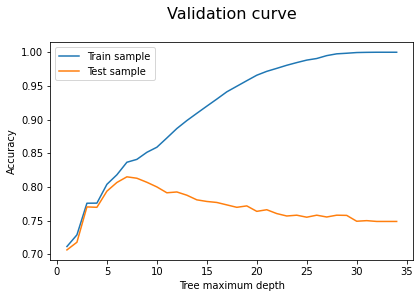

In [44]:
# Словари accuracy на тренировочной и тестовой выборках
train_scores = []
test_scores = []
# Перебираем значения max_deph
for max_depth in range(1,35):
    dtree = tree.DecisionTreeClassifier(
        criterion='entropy', random_state=42, max_depth=max_depth)
    dtree.fit(X_train, y_train)
    y_train_pred = dtree.predict(X_train)
    y_test_pred = dtree.predict(X_test)
    train_scores.append(metrics.accuracy_score(y_train, y_train_pred))
    test_scores.append(metrics.accuracy_score(y_test, y_test_pred))
    
# Рисунок
max_depth = list(range(1,35))
fig = plt.figure(figsize=(6.5, 4))
ax = sns.lineplot(x=max_depth, y=train_scores, label='Train sample')
sns.lineplot(x=max_depth, y=test_scores, label='Test sample')
ax.set(xlabel='Tree maximum depth', ylabel='Accuracy')
ax.set_title('Validation curve\n', fontsize=16);

# Оптимальный параметр
print(f'Максимальная точность на тесте: {np.amax(test_scores):.2f}')
print(f'Оптимальная глубина дерева: {np.argmax(test_scores)}')

Реализуем оптимизацию гиперпараметров с помощью GridSearch, перебрав следующие параметры:

'min_samples_split':    [2, 5, 7, 10];  
'max_depth':    [3,5,7].

In [45]:
estimator = tree.DecisionTreeClassifier(
    criterion='entropy', random_state=42)
param_grid = {'min_samples_split': [2, 5, 7, 10], 'max_depth': [3,5,7]}
gsearch = GridSearchCV(
    estimator=estimator, param_grid=param_grid, scoring='f1')
gsearch.fit(X_train, y_train)

y_train_pred = gsearch.predict(X_train)
y_test_pred = gsearch.predict(X_test)

print(f'Наилучшие значения гиперпараметров: {gsearch.best_params_}')
print('Обучающая выборка:\n{}'.format(
    metrics.classification_report(y_train, y_train_pred, digits=3)))
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred, digits=2)))

Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 7}
Обучающая выборка:
              precision    recall  f1-score   support

           0      0.859     0.831     0.845      3634
           1      0.811     0.842     0.827      3136

    accuracy                          0.836      6770
   macro avg      0.835     0.837     0.836      6770
weighted avg      0.837     0.836     0.836      6770

Тестовая выборка:
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      1790
           1       0.79      0.82      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.82      0.81      0.81      3335



# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

In [46]:
# Обучим случайный лес

rf = ensemble.RandomForestClassifier(
    n_estimators=100, criterion='gini', min_samples_leaf=5, 
    max_depth=10, random_state=42)
rf.fit(X_train, y_train)

y_test_pred = rf.predict(X_test)
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred, digits=3)))

Тестовая выборка:
              precision    recall  f1-score   support

           0      0.851     0.821     0.836      1790
           1      0.801     0.833     0.817      1545

    accuracy                          0.827      3335
   macro avg      0.826     0.827     0.826      3335
weighted avg      0.828     0.827     0.827      3335



In [47]:
# используем для классификации градиентный бустинг и сравните качество со случайным лесом

gboost = ensemble.GradientBoostingClassifier(
    learning_rate=0.05, n_estimators=300, min_samples_leaf=5,
    max_depth=5, random_state=42)
gboost.fit(X_train, y_train)

y_test_pred = gboost.predict(X_test)
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred, digits=3)))

Тестовая выборка:
              precision    recall  f1-score   support

           0      0.850     0.822     0.836      1790
           1      0.801     0.832     0.816      1545

    accuracy                          0.826      3335
   macro avg      0.825     0.827     0.826      3335
weighted avg      0.827     0.826     0.827      3335



Если посмотреть метрики в целом, модель Случайный лес даёт более качественный прогноз, чем модель Градиентный бустинг.

In [49]:
# Объединим с помощью стекинга следующие алгоритмы: 
# решающие деревья, логистическую регрессию и градиентный бустинг

dtree = tree.DecisionTreeClassifier(
    criterion='entropy', max_depth=7, min_samples_split=7, random_state=42)
logregr = linear_model.LogisticRegression(
    solver='sag', max_iter=1000, random_state=42)
gboost = ensemble.GradientBoostingClassifier(
    learning_rate=0.05, n_estimators=300, min_samples_leaf=5, 
    max_depth=5, random_state=42)

estimators = [
    ('dtree', dtree), ('logregr', logregr), ('gboost', gboost)]

stacked = ensemble.StackingClassifier(estimators=estimators)
stacked.fit(X_train, y_train)

y_test_pred = stacked.predict(X_test)
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred, digits=3)))

Тестовая выборка:
              precision    recall  f1-score   support

           0      0.836     0.835     0.835      1790
           1      0.809     0.810     0.810      1545

    accuracy                          0.823      3335
   macro avg      0.822     0.822     0.822      3335
weighted avg      0.823     0.823     0.823      3335



In [ ]:
# Оценим, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

gboost = ensemble.GradientBoostingClassifier(
    learning_rate=0.05, n_estimators=300, min_samples_leaf=5, 
    max_depth=5, random_state=42)
gboost.fit(X_train, y_train)
sorted(list(zip(selected_cols, gboost.feature_importances_)), 
       key=lambda x: x[1], reverse=True)

[('duration', 0.5071058721451662),
 ('poutcome_success', 0.11495825455712293),
 ('contact_unknown', 0.0725821275367475),
 ('balance', 0.057952124680919766),
 ('pdays', 0.055076964963864314),
 ('housing', 0.047725379385995914),
 ('age_group', 0.03990225428089572),
 ('month_mar', 0.02781861229822392),
 ('month_oct', 0.019880155415052014),
 ('month_may', 0.015214067775096997),
 ('campaign', 0.01477692667519217),
 ('month_sep', 0.013529992756930984),
 ('previous', 0.008448923987212045),
 ('contact_cellular', 0.003620125904267978),
 ('poutcome_unknown', 0.0014082176373116078)]

In [ ]:
# Реализуем оптимизацию гиперпараметров с помощью Optuna
# (реализуем для случайного леса)

def obj_func(trial):
    # пространство гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # модель
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42)
    
    # обучаем модель
    model.fit(X_train, y_train)
    score = cross_val_score(
        model, X_train, y_train, cv=5, scoring='f1').mean()
    
    return score


# Поиск оптимальных гиперпараметров
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(
    sampler=sampler, study_name='RF_Classifier', direction='maximize')
study.optimize(obj_func, n_trials=10)
print(f'Лучшие параметры:\n{study.best_params}')

[I 2022-08-29 23:44:33,454] A new study created in memory with name: RF_Classifier
[I 2022-08-29 23:44:35,701] Trial 0 finished with value: 0.8242786399729709 and parameters: {'n_estimators': 137, 'max_depth': 29, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8242786399729709.
[I 2022-08-29 23:44:38,490] Trial 1 finished with value: 0.8277058875416656 and parameters: {'n_estimators': 160, 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8277058875416656.
[I 2022-08-29 23:44:40,209] Trial 2 finished with value: 0.8245238752494883 and parameters: {'n_estimators': 105, 'max_depth': 28, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8277058875416656.
[I 2022-08-29 23:44:42,786] Trial 3 finished with value: 0.819955624378846 and parameters: {'n_estimators': 171, 'max_depth': 10, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.8277058875416656.
[I 2022-08-29 23:44:46,054] Trial 4 finished with value: 0.8266535615983163 and parameters: {'n_estimator

Лучшие параметры:
{'n_estimators': 160, 'max_depth': 13, 'min_samples_leaf': 3}


In [ ]:
# Модель с лучшими параметрами  
rf_best = ensemble.RandomForestClassifier(
    **study.best_params, random_state=42)
rf_best.fit(X_train, y_train)
y_test_pred = rf_best.predict(X_test)
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred, digits=3)))

Тестовая выборка:
              precision    recall  f1-score   support

           0      0.856     0.817     0.836      1790
           1      0.799     0.841     0.819      1545

    accuracy                          0.828      3335
   macro avg      0.827     0.829     0.828      3335
weighted avg      0.830     0.828     0.828      3335



## Общий вывод

Проведена предобработка признаков. Простыми способами (медиана, мода) заменены пропущенные значения. Методом Тьюки удалены выбросы баланса.  
Проведен разведывательный анализ данных в контексте влияния на целевой признак.  
Проведено кодирование признаков и масштабирование значений. Не проводилась трансформация признаков к нормальному распределению.  
На основе корреляции Пирсона проведен анализ мультиколлинеарности.   
С помощью ANOVA F-value (f_classif) дана оценка влияния признаков на целевой признак, для построения моделей отобраны 15 наиболее значимых признаков.  
Построены простые базовые модели - логистическая регрессия и решающее дерево.  
Построены ансамблевые модели - случайный лес, градиентный бустинг на решающих деревьх, стекинг из деревьев, регрессии и бустинга.  
Реализованы примеры подбора гиперпараметров - поиск по сетке, Tree-structured Parzen estimator (в Optuna).  
На каждом этапе моделирования оценивались метрики качества классификации. Ансамблевые решения закономерно показывают лучшие значения. Какая либо качественная разница между ансамблевыми моделями на данном датасете не прослеживается. Подбор гиперпараметров модели случайного леса незначительно улучшил результат.  